# 0 - IMPORTS

In [1]:
import re
import numpy        as np
import pandas       as pd
import seaborn      as sns
import umap.umap_   as umap

from matplotlib     import pyplot       as plt
from plotly         import express      as px

from sklearn                 import cluster              as c
from sklearn                 import metrics              as m
from sklearn                 import preprocessing        as pp
from sklearn                 import decomposition        as dd
from sklearn                 import ensemble             as en
from sklearn                 import mixture              as mx
from sklearn.manifold        import TSNE                 as mn

from scipy.cluster           import hierarchy            as hc

from yellowbrick.cluster     import KElbowVisualizer, SilhouetteVisualizer
#from pandas_profiling        import ProfileReport

## 0.1 - Helper functions

## 0.2 - Load dataset

In [2]:
# load data
df_raw = pd.read_csv('dataset/Ecommerce.csv', encoding = 'unicode_escape')

# drop extra column
df_raw = df_raw.drop('Unnamed: 8', axis=1)

# 1 - Descrição dos dados

In [3]:
df1 = df_raw.copy()

## 1.1 - Rename columns

In [4]:
cols_new = ['invoice_no', 'stock_code', 'description', 'quantity', 'invoice_date', 'unit_price', 'customer_id', 'country']
df1.columns = cols_new

## 1.2 - Data dimensions

In [5]:
print('Number of rows: {}'.format(df1.shape[0]))
print('Number of columns: {}'.format(df1.shape[1]))

Number of rows: 541909
Number of columns: 8


## 1.3 Data types

In [6]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

## 1.4 - Check NA

In [7]:
df1.isna().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

## 1.5 - Replace NA

In [8]:
df_missing = df1.loc[df1['customer_id'].isna(), :]
df_not_missing = df1.loc[~df1['customer_id'].isna(), :]

In [9]:
# create reference
df_backup = pd.DataFrame(df_missing['invoice_no'].drop_duplicates())
df_backup['customer_id'] = np.arange(19000, 19000+len(df_backup), 1)

# merge original with reference dataframe
df1 = pd.merge(df1, df_backup, how='left', on='invoice_no')

# coalesce
df1['customer_id'] = df1['customer_id_x'].combine_first(df1['customer_id_y'])
df1 = df1.drop(['customer_id_x', 'customer_id_y'], axis=1)
df1.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,United Kingdom,17850.0
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,United Kingdom,17850.0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,United Kingdom,17850.0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,United Kingdom,17850.0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,United Kingdom,17850.0


In [10]:
df1.isna().sum()

invoice_no         0
stock_code         0
description     1454
quantity           0
invoice_date       0
unit_price         0
country            0
customer_id        0
dtype: int64

## 1.6 - Change Dtypes

In [11]:
# invoice_date
df1['invoice_date'] = pd.to_datetime(df1['invoice_date'], format='%d-%b-%y')

# customer_id
df1['customer_id'] = df1['customer_id'].astype(int)

In [12]:
df1.dtypes

invoice_no              object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
unit_price             float64
country                 object
customer_id              int64
dtype: object

## 1.7 Descriptive statistics

In [13]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

### 1.7.1 - Numerical Attributes

In [14]:
# central tendency - mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(np.min)).T
d3 = pd.DataFrame(num_attributes.apply(np.max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max()-x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

# concat
stats = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
stats .columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
stats

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,quantity,-80995.00,80995.0,161990.00,9.552250,3.00,218.080957,-0.264076,119769.160031
1,unit_price,-11062.06,38970.0,50032.06,4.611114,2.08,96.759764,186.506972,59005.719097
2,customer_id,12346.00,22709.0,10363.00,16688.840453,16249.00,2911.408666,0.487449,-0.804287


### 1.7.2 - Categorical Attributes

#### invoice_no

In [15]:
# invoice_no: Há letras e números nas strings, não se transforma em int
n_diff = len(cat_attributes.loc[cat_attributes['invoice_no'].apply(lambda x: bool(re.search('[^0-9]+', x))), 'invoice_no'].drop_duplicates())
perc = n_diff/cat_attributes['invoice_no'].drop_duplicates().shape[0]
print('Qtde de valores com letras: {}  |  Representatividade: {}'.format(n_diff, str(np.round(perc*100,2))+'%'))

Qtde de valores com letras: 3839  |  Representatividade: 14.82%


#### stock_code

In [16]:
# stock code
n_diff = len(cat_attributes.loc[cat_attributes['stock_code'].apply(lambda x: bool(re.search('[^0-9]+', x))), 'stock_code'].drop_duplicates())
perc = n_diff/cat_attributes['stock_code'].drop_duplicates().shape[0]
print('Qtde de valores com letras: {}  |  Representatividade: {}'.format(n_diff, str(np.round(perc*100,2))+'%'))

Qtde de valores com letras: 1124  |  Representatividade: 27.62%


In [17]:
df1.loc[df1['stock_code'].apply(lambda x: bool(re.search('^[a-zA-Z]+$', x))), 'stock_code'].unique()

array(['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY',
       'DCGSSGIRL', 'PADS', 'B', 'CRUK'], dtype=object)

# 2 - Filtragem de variáveis

In [18]:
df2 = df1.copy()

In [19]:
# Numerical Attributes
# unit_price >0.0
df2 = df2.loc[df2['unit_price']>0.0, :]

# stock_code != [POST, D, M, DOT, CRUK, C2]
df2 = df2[~df2['stock_code'].isin(['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY',
                                   'DCGSSGIRL', 'PADS', 'B', 'CRUK'])]

# description
df2 = df2.drop('description', axis=1)

# map - 
df2 = df2[~df2['country'].isin(['European Community', 'Unspecified'])]

# bad users
df2 = df2[~df2['customer_id'].isin([16446])]

# quantity - negative numbers means product returns
df2_returns = df2.loc[df2['quantity']<0,:]
df2_purchase = df2.loc[df2['quantity']>0,:]

# 3 - Feature engineering

In [20]:
df3 = df2.copy()

In [21]:
# data reference
df_ref = df3[['customer_id']].copy()
df_ref = df_ref.drop_duplicates(ignore_index=True)

## 3.1 - Gross Revenue | Monetary

In [22]:
# gross_revenue (Faturamento = quantity * unit_price)
df2_purchase.loc[:, 'gross_revenue'] = df2_purchase.loc[:, 'quantity']*df2_purchase.loc[:, 'unit_price']

# monetary
df_monetary = df2_purchase.loc[:, ['customer_id', 'gross_revenue']].groupby('customer_id').sum().reset_index()
df_ref = pd.merge(df_ref, df_monetary, on='customer_id', how='left')
df_ref.isna().sum()

/tmp/ipykernel_22845/203412114.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2_purchase.loc[:, 'gross_revenue'] = df2_purchase.loc[:, 'quantity']*df2_purchase.loc[:, 'unit_price']


customer_id       0
gross_revenue    91
dtype: int64

## 3.2 - Recency - Day from last purchase

In [23]:
# recency - last day purchase
df_recency = df2_purchase.loc[:, ['customer_id', 'invoice_date']].groupby('customer_id').max().reset_index()
df_recency['recency_days'] = (df3['invoice_date'].max() - df_recency['invoice_date']).dt.days
df_ref = pd.merge(df_ref, df_recency[['customer_id', 'recency_days']], how='left', on='customer_id')
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
dtype: int64

## 3.3 - Quantity of purchased

In [24]:
# frequency
df_freq = df2_purchase.loc[:, ['customer_id', 'invoice_no']].drop_duplicates().groupby('customer_id').count().reset_index().rename(columns={'invoice_no': 'qtde_invoices'})
df_ref = pd.merge(df_ref, df_freq, how='left', on='customer_id')
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
qtde_invoices    91
dtype: int64

## 3.3 - Quantity of items purchased

In [25]:
# frequency
df_freq = df2_purchase.loc[:, ['customer_id', 'quantity']].groupby('customer_id').sum().reset_index().rename(columns={'quantity': 'qtde_items'})
df_ref = pd.merge(df_ref, df_freq, how='left', on='customer_id')
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
qtde_invoices    91
qtde_items       91
dtype: int64

## 3.3 - Quantity of products purchased

In [26]:
# frequency
df_freq = df2_purchase.loc[:, ['customer_id', 'stock_code']].groupby('customer_id').count().reset_index().rename(columns={'stock_code': 'qtde_products'})
df_ref = pd.merge(df_ref, df_freq, how='left', on='customer_id')
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
qtde_invoices    91
qtde_items       91
qtde_products    91
dtype: int64

## 3.4 - Average Ticket Value

In [27]:
# Avg Ticket
df_avg_ticket = df2_purchase.loc[:, ['customer_id', 'gross_revenue']].groupby('customer_id').mean().reset_index().rename(columns={'gross_revenue': 'avg_ticket'})
df_ref = pd.merge(df_ref, df_avg_ticket, how='left', on='customer_id')
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
qtde_invoices    91
qtde_items       91
qtde_products    91
avg_ticket       91
dtype: int64

## 3.5 - Average recency days

In [28]:
df_aux = df2[['customer_id', 'invoice_date']].drop_duplicates().sort_values(['customer_id', 'invoice_date'], ascending=(False, False))
df_aux['next_customer_id'] = df_aux['customer_id'].shift(-1) # next customer
df_aux['previous_date'] = df_aux['invoice_date'].shift(-1) # next invoice date
df_aux['avg_recency_days'] = df_aux.apply(lambda x: (x['invoice_date'] - x['previous_date']).days if x['customer_id'] == x['next_customer_id'] else np.nan, axis=1)
df_aux = df_aux.drop(['invoice_date', 'next_customer_id', 'previous_date'], axis=1).dropna()

# average_recency
df_avg_recency_days = df_aux.groupby('customer_id').mean().reset_index()
df_ref = pd.merge(df_ref, df_avg_recency_days, on='customer_id', how='left')
df_ref.isna().sum()

customer_id            0
gross_revenue         91
recency_days          91
qtde_invoices         91
qtde_items            91
qtde_products         91
avg_ticket            91
avg_recency_days    2816
dtype: int64

## 3.6 - Frequency purchase

In [29]:
df_aux = (df2[['invoice_no', 'customer_id', 'invoice_date']].drop_duplicates().groupby('customer_id')
                                                            .agg(max_ = ('invoice_date', 'max'),
                                                                 min_ = ('invoice_date', 'min'),
                                                                 days_ = ('invoice_date', lambda x: (x.max() - x.min()).days + 1),
                                                                 buy_ = ('invoice_no', 'count')).reset_index())
        
# frequency
df_aux['frequency'] = df_aux[['buy_', 'days_']].apply(lambda x: x['buy_']/x['buy_'] if x['days_']!=0 else 0, axis=1)
df_ref = pd.merge(df_ref, df_aux[['customer_id', 'frequency']], on='customer_id', how='left')
df_ref.isna().sum()

customer_id            0
gross_revenue         91
recency_days          91
qtde_invoices         91
qtde_items            91
qtde_products         91
avg_ticket            91
avg_recency_days    2816
frequency              0
dtype: int64

## 3.7 - Number of returns

In [30]:
df_returns = df2_returns[['customer_id', 'quantity']].groupby('customer_id').sum().reset_index().rename(columns={'quantity': 'qtde_returns'})
df_returns['qtde_returns'] = -1*df_returns['qtde_returns']
df_ref = pd.merge(df_ref, df_returns, on='customer_id', how='left')
df_ref.loc[df_ref['qtde_returns'].isna(), 'qtde_returns'] = 0
df_ref.isna().sum()

customer_id            0
gross_revenue         91
recency_days          91
qtde_invoices         91
qtde_items            91
qtde_products         91
avg_ticket            91
avg_recency_days    2816
frequency              0
qtde_returns           0
dtype: int64

## 3.8 - Basket Size - Quantidade de itens por cesta (quantity)

In [31]:
df_aux = (df2_purchase.loc[:, ['customer_id', 'invoice_no', 'quantity']].groupby('customer_id')
                                                                        .agg(n_purchase=('invoice_no', 'nunique'),
                                                                             n_products=('quantity', 'sum'))
                                                                        .reset_index())

df_aux['avg_basket_size'] = df_aux['n_products']/df_aux['n_purchase']
df_ref = pd.merge(df_ref, df_aux[['customer_id', 'avg_basket_size']], on='customer_id', how='left')
df_ref.isna().sum()

customer_id            0
gross_revenue         91
recency_days          91
qtde_invoices         91
qtde_items            91
qtde_products         91
avg_ticket            91
avg_recency_days    2816
frequency              0
qtde_returns           0
avg_basket_size       91
dtype: int64

## 3.9 - Unique Basket Size - Quantidade de produtos distintos por compra

In [32]:
df_aux = (df2_purchase.loc[:, ['customer_id', 'invoice_no', 'stock_code']].groupby('customer_id')
                                                                        .agg(n_purchase=('invoice_no', 'nunique'),
                                                                             n_products=('stock_code', 'nunique'))
                                                                        .reset_index())

df_aux['avg_unique_basket_size'] = df_aux['n_products']/df_aux['n_purchase']
df_ref = pd.merge(df_ref, df_aux[['customer_id', 'avg_unique_basket_size']], on='customer_id', how='left')
df_ref.isna().sum()

customer_id                  0
gross_revenue               91
recency_days                91
qtde_invoices               91
qtde_items                  91
qtde_products               91
avg_ticket                  91
avg_recency_days          2816
frequency                    0
qtde_returns                 0
avg_basket_size             91
avg_unique_basket_size      91
dtype: int64

# 4 - Análise exploratória de dados (EDA)

In [33]:
df4 = df_ref.dropna()
df4.isna().sum()

customer_id               0
gross_revenue             0
recency_days              0
qtde_invoices             0
qtde_items                0
qtde_products             0
avg_ticket                0
avg_recency_days          0
frequency                 0
qtde_returns              0
avg_basket_size           0
avg_unique_basket_size    0
dtype: int64

## 4.1 - Univariete Analysis

## 4.2 - Bivariate Analysis

<Figure size 2500x1200 with 0 Axes>

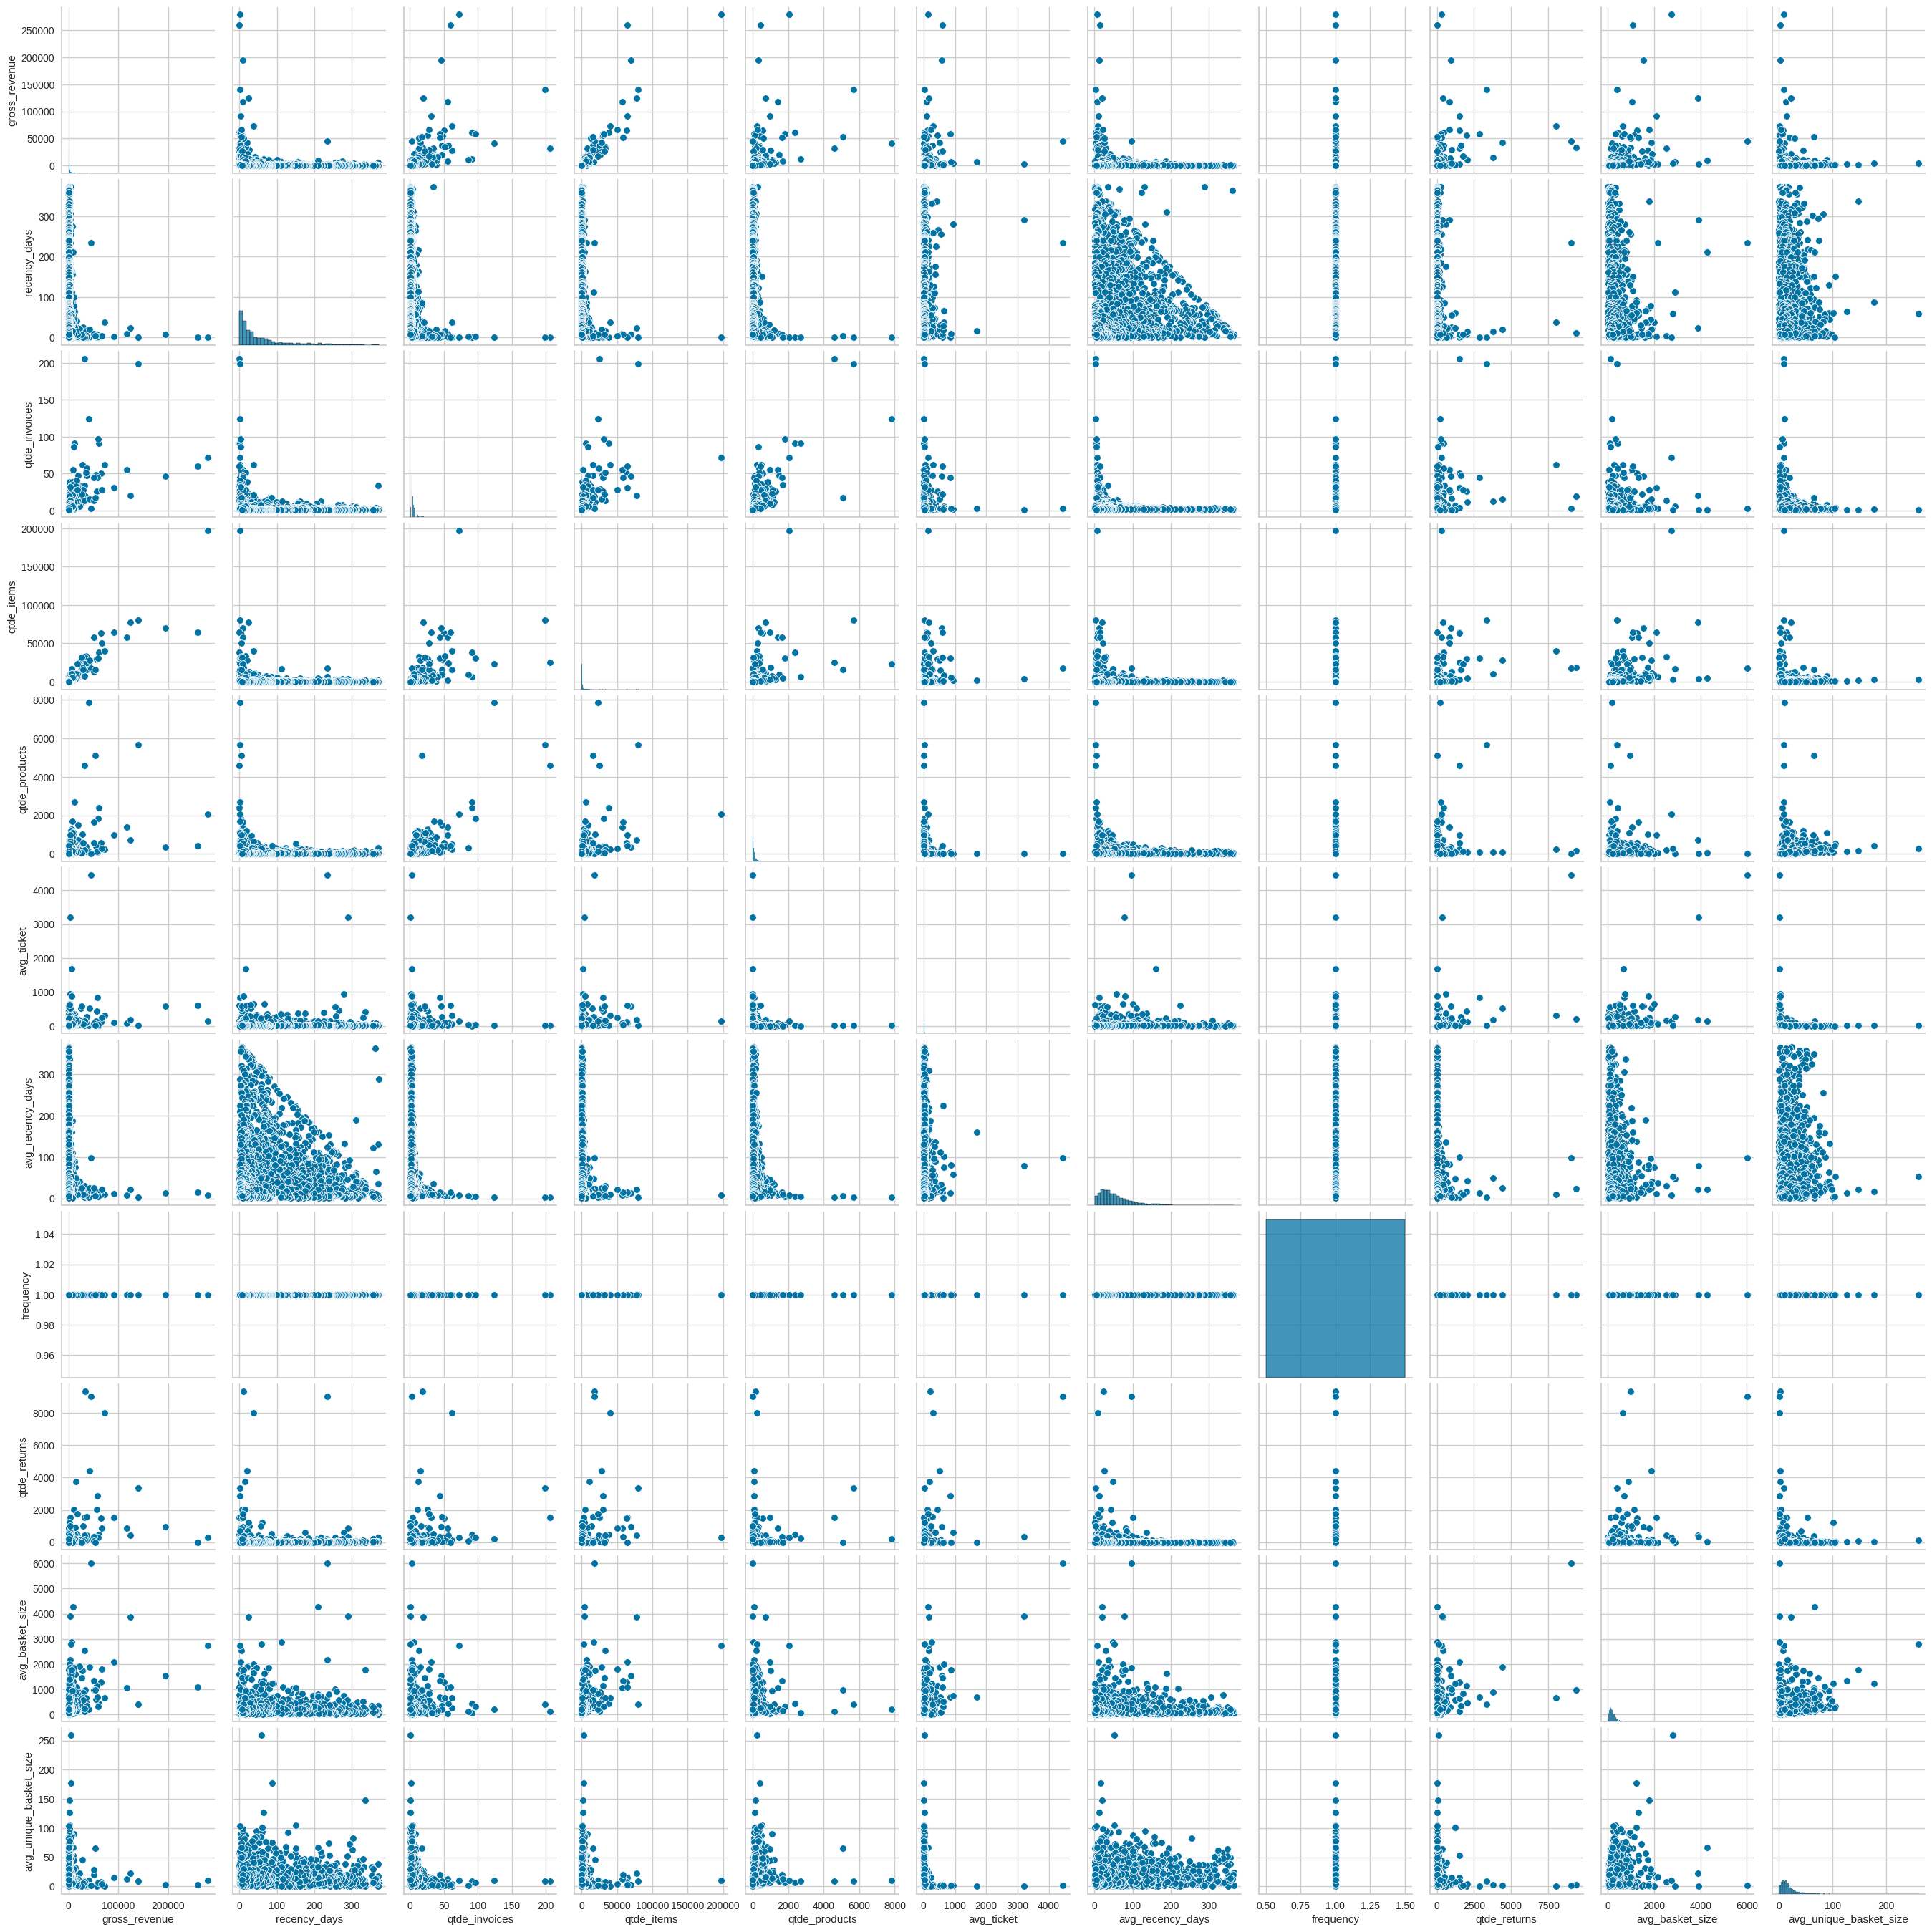

In [34]:
df42 = df4.drop('customer_id', axis=1)
plt.figure(figsize=[25, 12])
sns.pairplot(df42);

## 4.3 - Estudo de espaço

In [35]:
df43 = df4.drop('customer_id', axis=1)

In [36]:
mms = pp.MinMaxScaler()

df43['gross_revenue'] = mms.fit_transform(df43[['gross_revenue']])
df43['recency_days'] = mms.fit_transform(df43[['recency_days']])
df43['avg_ticket'] = mms.fit_transform(df43[['avg_ticket']])
df43['qtde_invoices'] = mms.fit_transform(df43[['qtde_invoices']])
df43['qtde_items'] = mms.fit_transform(df43[['qtde_items']])
df43['qtde_products'] = mms.fit_transform(df43[['qtde_products']])
df43['avg_recency_days'] = mms.fit_transform(df43[['avg_recency_days']])
df43['avg_basket_size'] = mms.fit_transform(df43[['avg_basket_size']])
df43['frequency'] = mms.fit_transform(df43[['frequency']])
df43['qtde_returns'] = mms.fit_transform(df43[['qtde_returns']])

X = df43.copy()

### 4.3.1 - PCA

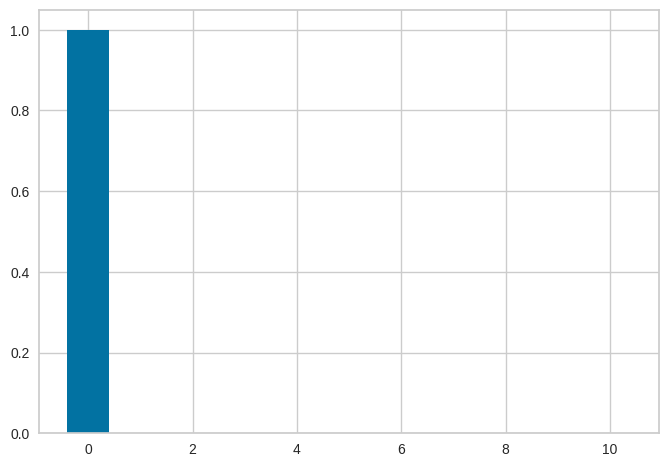

In [37]:
pca = dd.PCA(n_components=X.shape[1])
principal_components = pca.fit_transform(X)

# plot explained variable
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_)

# pca component
df_pca = pd.DataFrame(principal_components)

<AxesSubplot:xlabel='0', ylabel='1'>

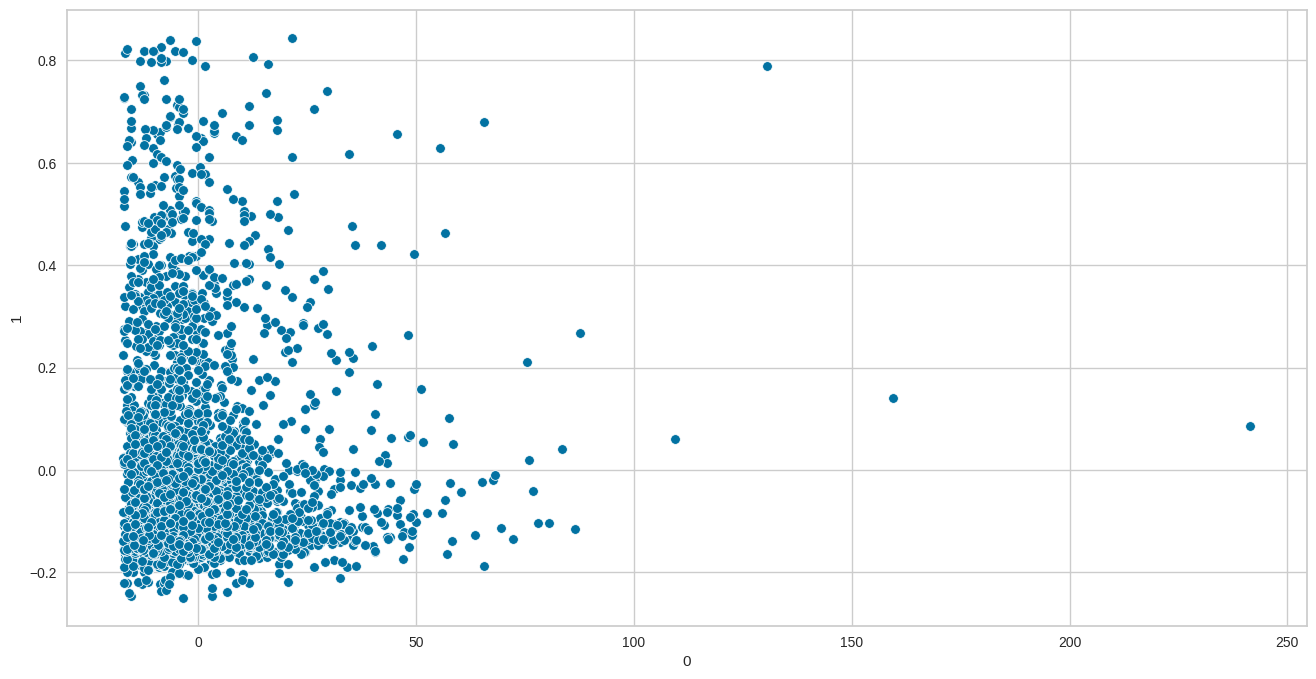

In [38]:
plt.figure(figsize=[16, 8])
sns.scatterplot(x=0, y=1, data=df_pca)

### 4.3.2 - UMAP

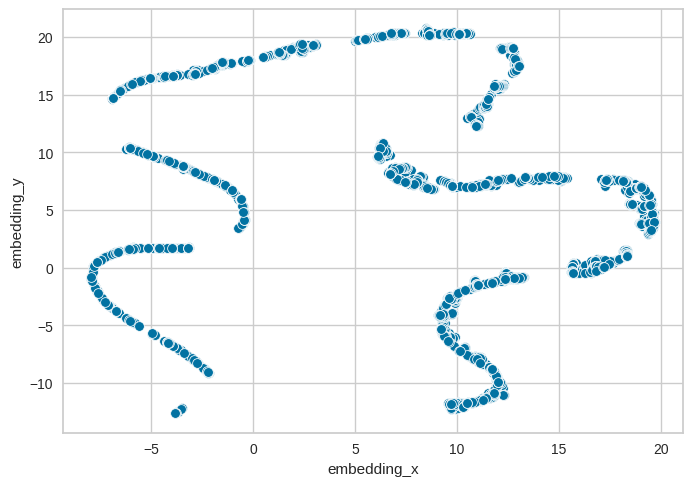

In [39]:
reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(X)

# embedding
df_pca['embedding_x'] = embedding[:, 0]
df_pca['embedding_y'] = embedding[:, 1]

#plot UMAP
sns.scatterplot(x='embedding_x', y='embedding_y', data=df_pca);

### 4.3.2 - t-SNE

/home/fausto/repos/clustering/cluster/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/fausto/repos/clustering/cluster/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


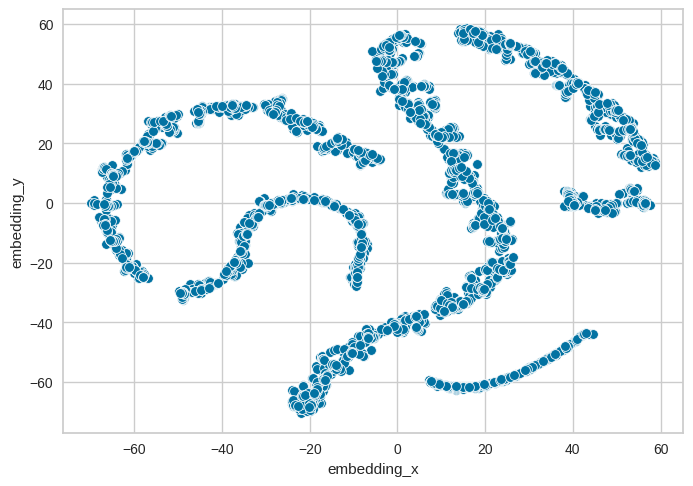

In [41]:
reducer = mn(n_components=2, n_jobs=-1, random_state=42)
embedding = reducer.fit_transform(X)

# embedding
df_pca['embedding_x'] = embedding[:, 0]
df_pca['embedding_y'] = embedding[:, 1]

#plot UMAP
sns.scatterplot(x='embedding_x', y='embedding_y', data=df_pca);

### 4.3.3 - Tree-Based Embedding

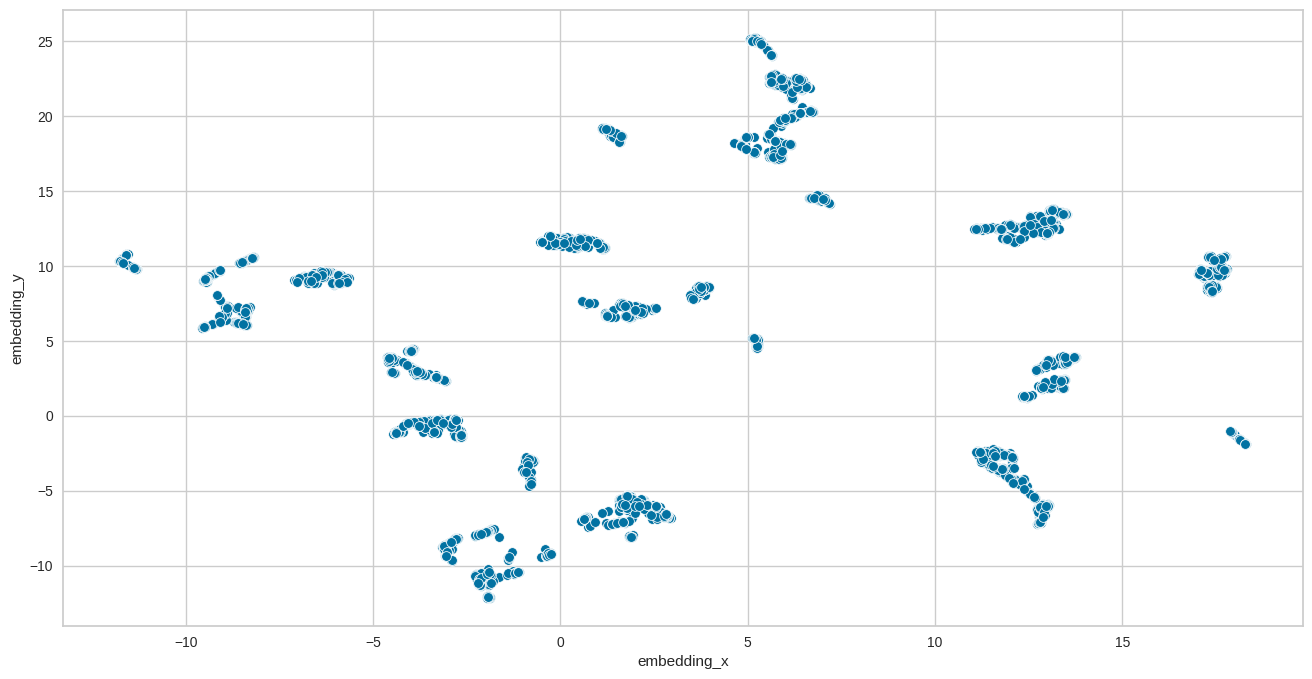

In [42]:
# training dataset
X = df4.drop(['customer_id', 'gross_revenue'], axis=1)
y = df4['gross_revenue']

# model definition
rf_model = en.RandomForestRegressor(n_estimators=100, random_state=42)

# model training
rf_model.fit(X, y)

# Leaf
df_leaf = pd.DataFrame(rf_model.apply(X))



# umap
reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(df_leaf)

# embedding
df_pca['embedding_x'] = embedding[:, 0]
df_pca['embedding_y'] = embedding[:, 1]

#plot UMAP
plt.figure(figsize=[16, 8])
sns.scatterplot(x='embedding_x', y='embedding_y', data=df_pca);

# 5 - Data preparation

In [43]:
df5 = df4.copy()

In [44]:
# MinMax Scaler
mms = pp.MinMaxScaler()

df5['gross_revenue'] = mms.fit_transform(df5[['gross_revenue']])
df5['recency_days'] = mms.fit_transform(df5[['recency_days']])
df5['qtde_invoices'] = mms.fit_transform(df5[['qtde_invoices']])
df5['qtde_items'] = mms.fit_transform(df5[['qtde_items']])
df5['qtde_products'] = mms.fit_transform(df5[['qtde_products']])
df5['avg_ticket'] = mms.fit_transform(df5[['avg_ticket']])
df5['avg_recency_days'] = mms.fit_transform(df5[['avg_recency_days']])
df5['frequency'] = mms.fit_transform(df5[['frequency']])
df5['qtde_returns'] = mms.fit_transform(df5[['qtde_returns']])
df5['avg_basket_size'] = mms.fit_transform(df5[['avg_basket_size']])
df5['avg_unique_basket_size'] = mms.fit_transform(df5[['avg_unique_basket_size']])

# 6 - Feature selection

In [45]:
df6 = df5.copy()

# 7 - Hyperparameter fine-tuning

In [46]:
X = df6.drop('customer_id', axis=1)

In [47]:
clusters = [2, 3, 4, 5, 6, 7]

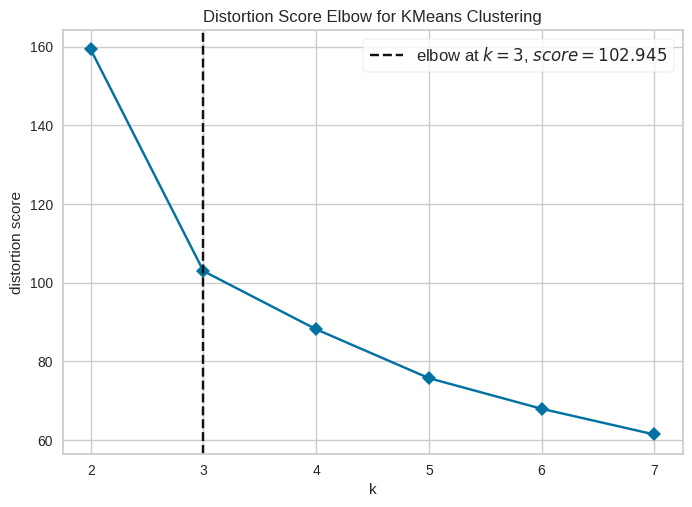

In [48]:
# WSS
kmeans = KElbowVisualizer(c.KMeans(), k=clusters, timings=False)
kmeans.fit(X)
kmeans.show();

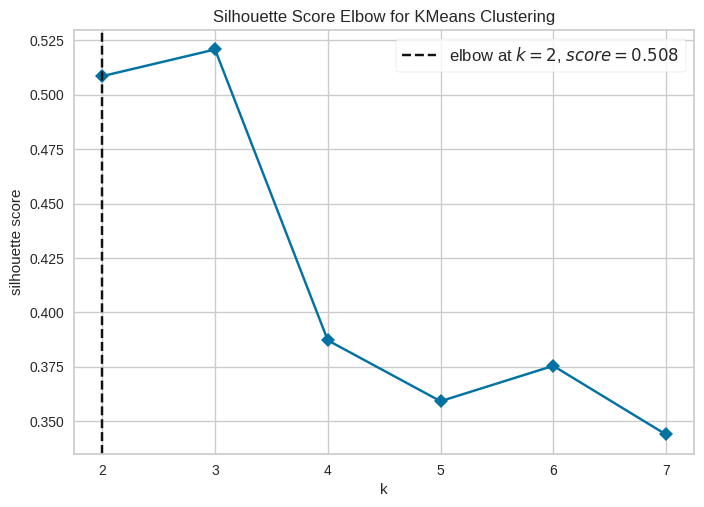

In [49]:
# Silhouette
kmeans = KElbowVisualizer(c.KMeans(), k=clusters, metric='silhouette', timings=False)
kmeans.fit(X)
kmeans.show();

## 7.1.2 - Silhouette Analysis

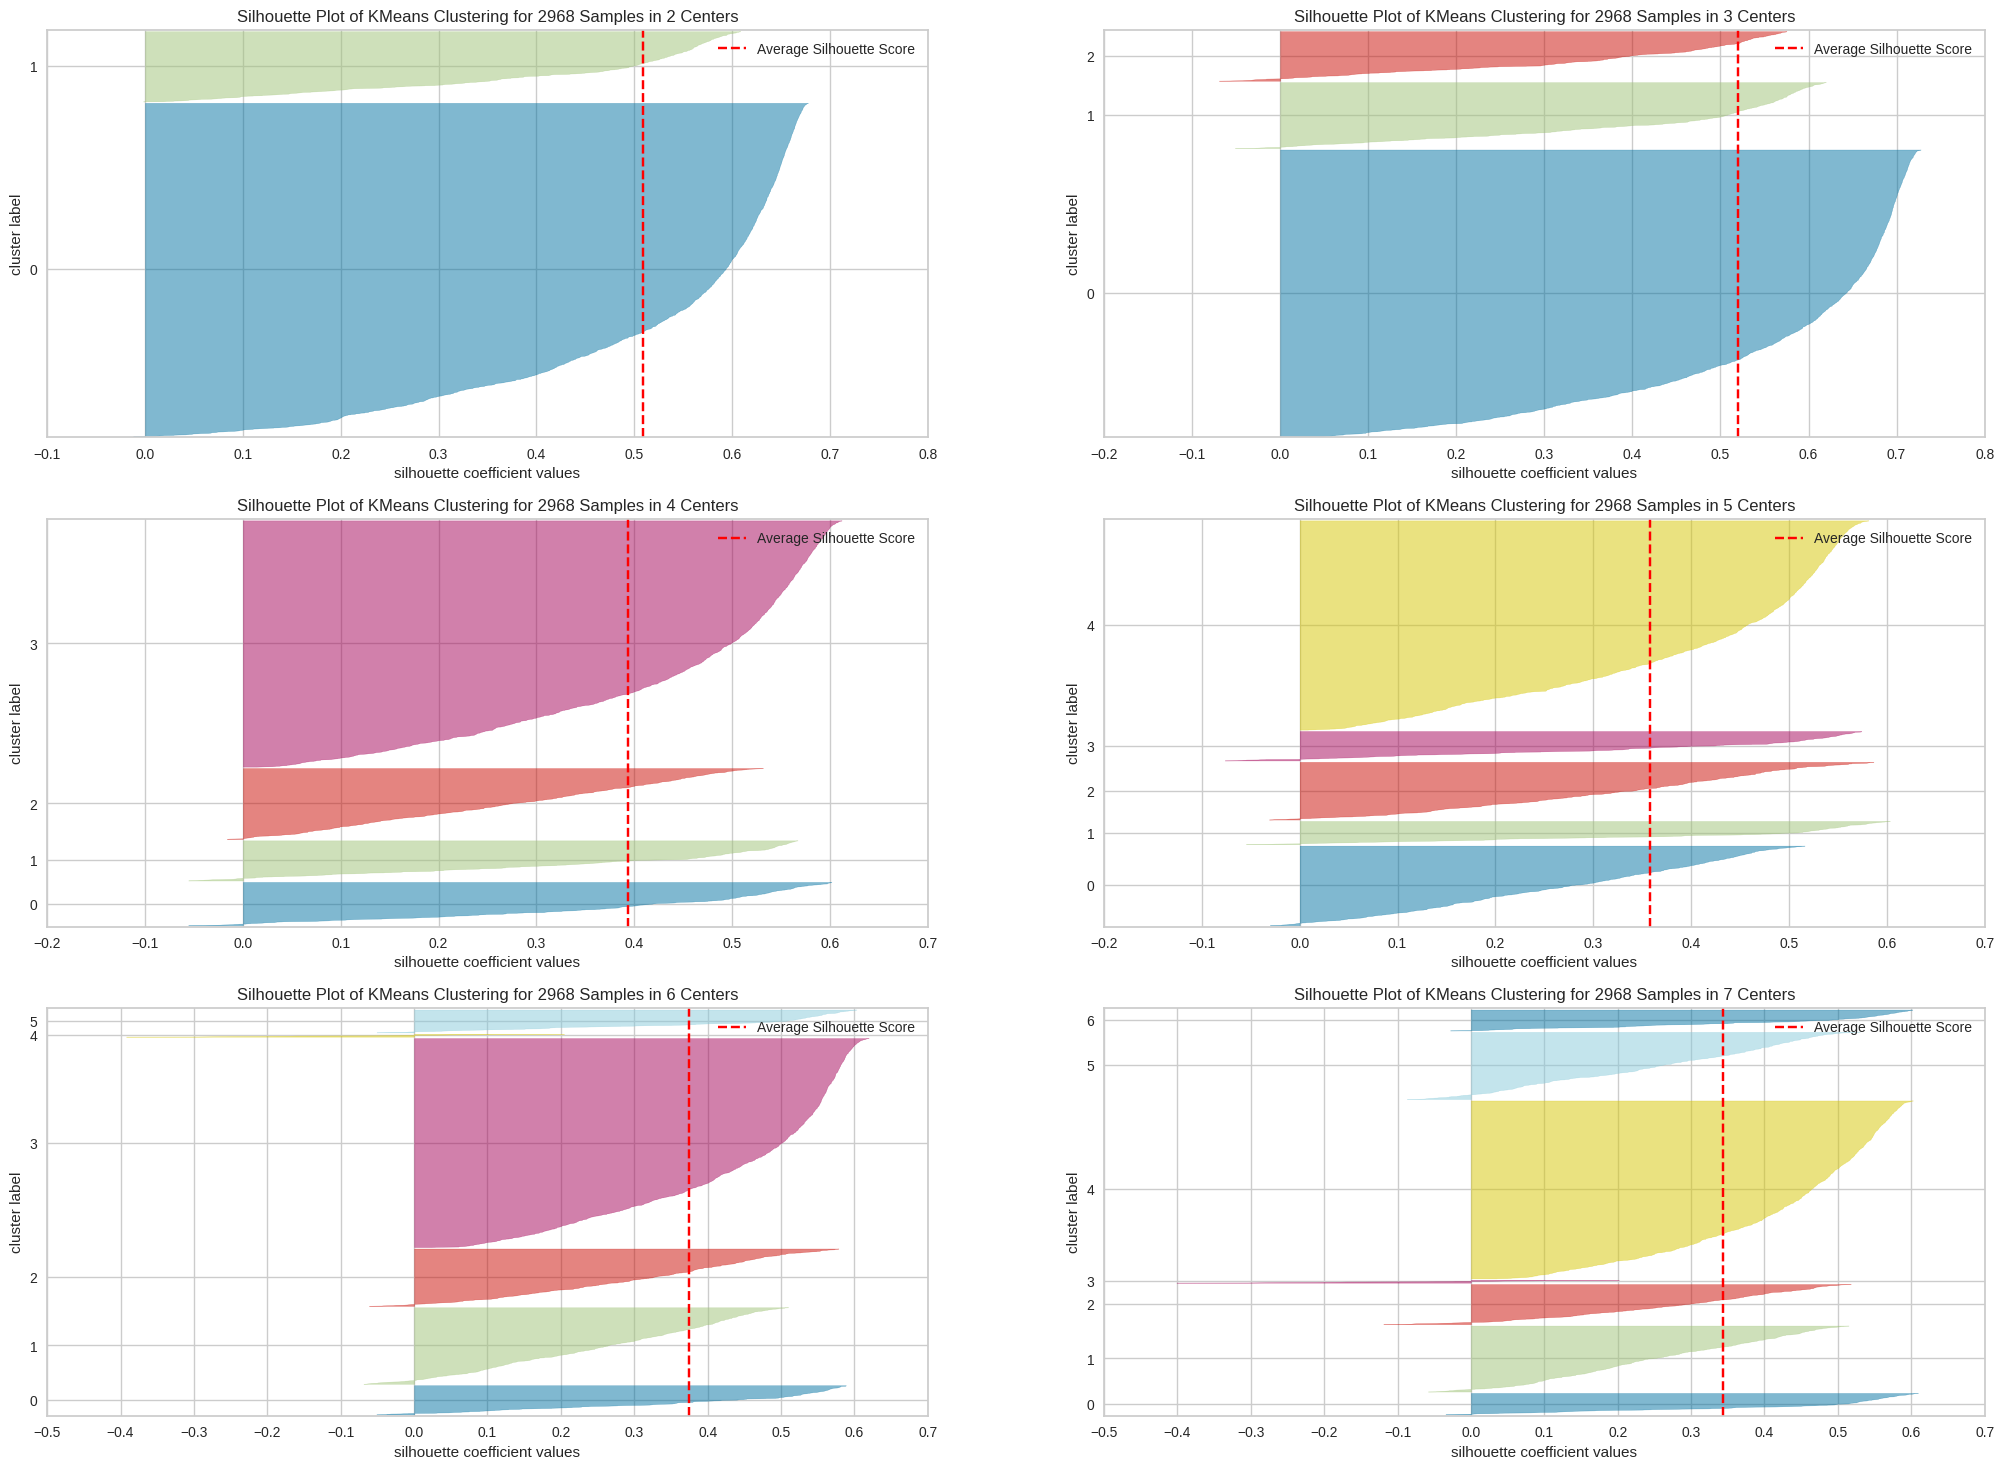

In [50]:
fig, ax = plt.subplots(3, 2, figsize=(25, 18))
for k in clusters:
    km = c.KMeans(n_clusters=k, init='random', n_init=10, max_iter=100, random_state=42)
    q, mod = divmod(k, 2)
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(X)
    visualizer.finalize();

## 7.1 - K-Means

In [51]:
kmeans_list = []
for k in clusters:
    # model definition
    kmeans_model = c.KMeans(n_clusters=k)
    
    # model training
    kmeans_model.fit(X)
    
    # model predict
    labels = kmeans_model.predict(X)
    
    # model performance
    sil = m.silhouette_score(X, labels, metric='euclidean')
    kmeans_list.append(sil)

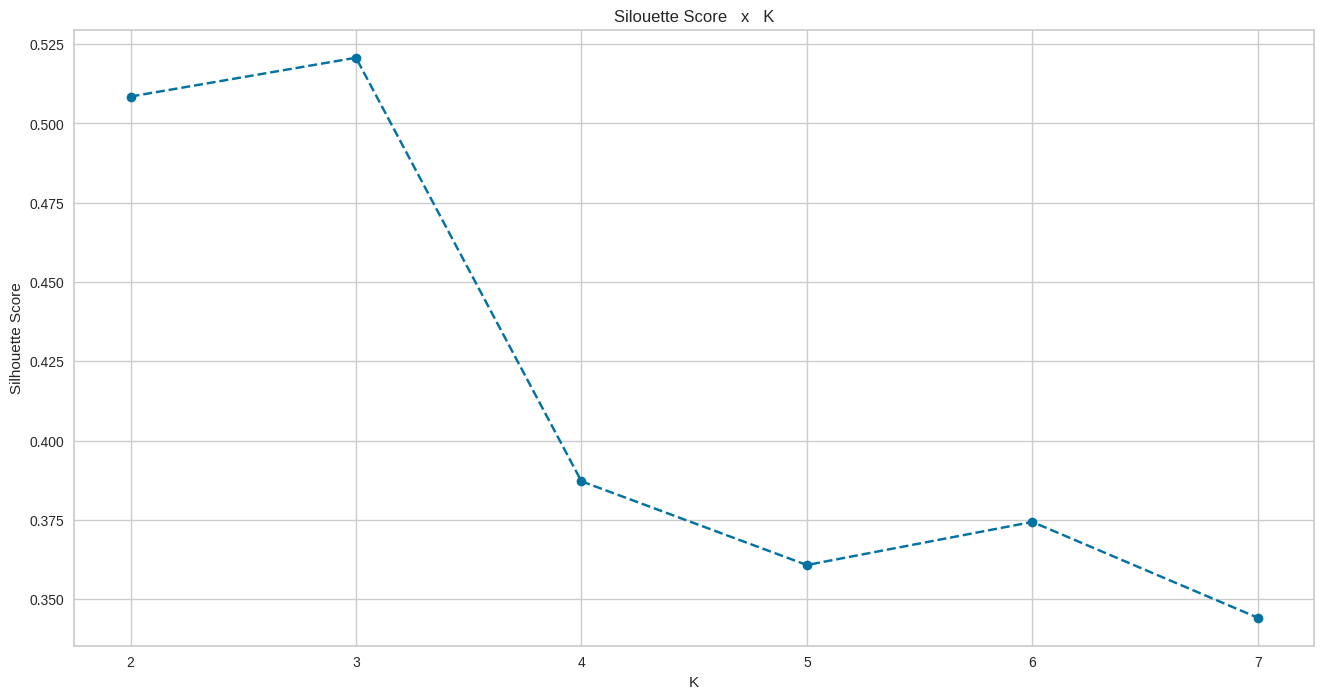

In [52]:
plt.figure(figsize=[16,8])
plt.plot(clusters, kmeans_list, linestyle='--', marker='o', color='b')
plt.xlabel('K')
plt.ylabel('Silhouette Score')
plt.title('Silouette Score   x   K');

## 7.2 Gaussian Mixture Model (GMM)

In [53]:
gmm_list = []

for k in clusters:
    # model definition
    gmm_model = mx.GaussianMixture(n_components=k)
    
    # model training
    gmm_model.fit(X)
    
    # model predict
    labels = gmm_model.predict(X)
    
    # model performance
    sil = m.silhouette_score(X, labels, metric='euclidean')
    gmm_list.append(sil)

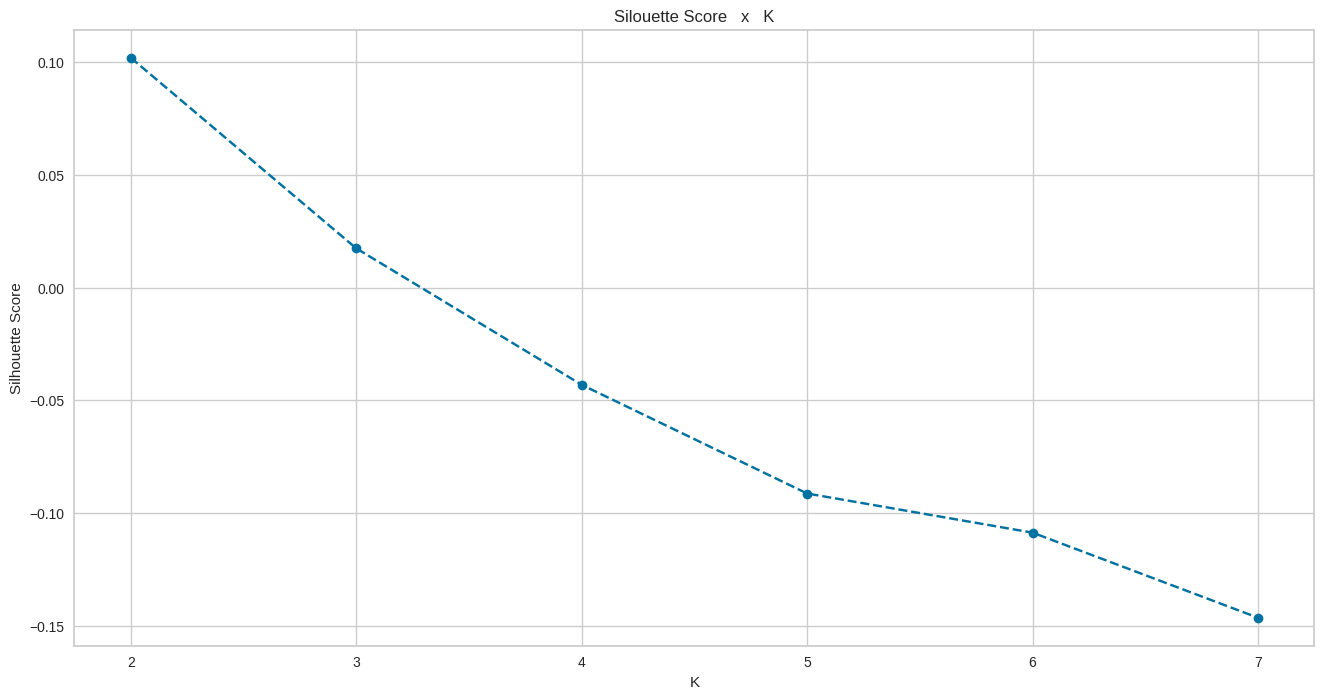

In [54]:
plt.figure(figsize=[16,8])
plt.plot(clusters, gmm_list, linestyle='--', marker='o', color='b')
plt.xlabel('K')
plt.ylabel('Silhouette Score')
plt.title('Silouette Score   x   K');

## 7.3 - Hierarchial Clustering

In [55]:
# model definition and training
hc_model = hc.linkage(X, 'ward')

[]

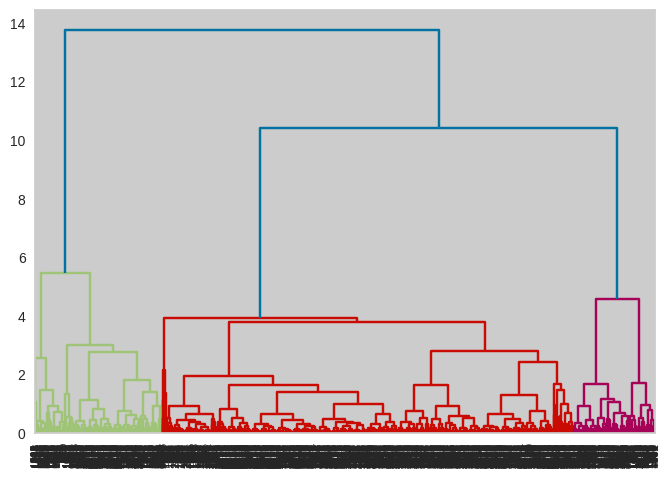

In [56]:
hc.dendrogram(
    hc_model,
    leaf_rotation=90,
    leaf_font_size=8
)

plt.plot()

[]

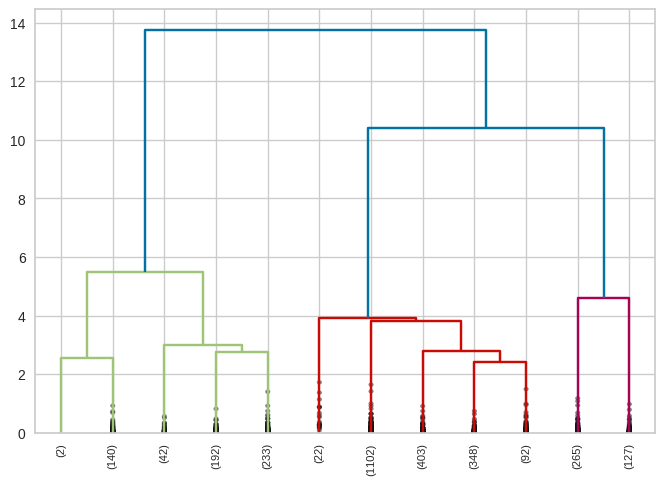

In [57]:
hc.dendrogram(
    hc_model,
    truncate_mode='lastp',
    p=12,
    leaf_rotation=90,
    leaf_font_size=8,
    show_contracted=True
)

plt.plot()

### 7.3.1 - HClustering Silhouette Score

In [58]:
hc_list = []
for k in clusters:
    # model definition and training
    hc_model = hc.linkage(X, 'ward')
    
    # model predict
    labels = hc.fcluster(hc_model, k, criterion='maxclust')
    
    # metrics
    sil = m.silhouette_score(X, labels, metric='euclidean')
    hc_list.append(sil)

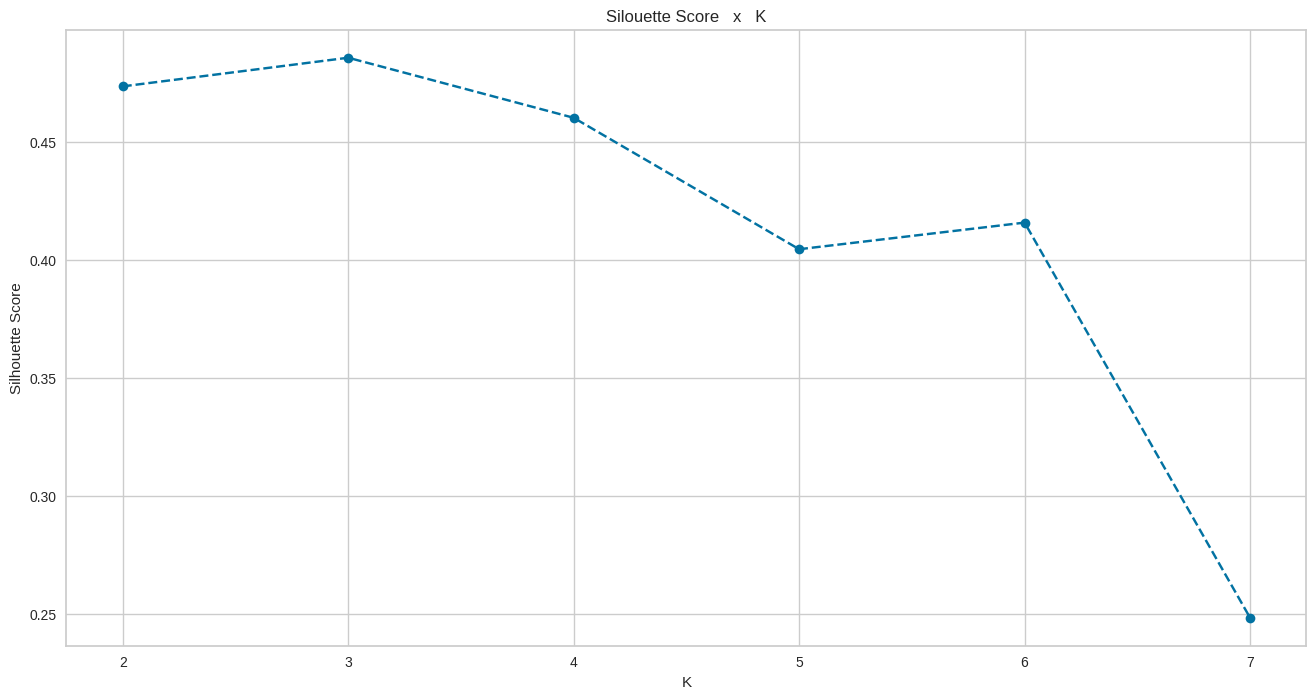

In [59]:
plt.figure(figsize=[16,8])
plt.plot(clusters, hc_list, linestyle='--', marker='o', color='b')
plt.xlabel('K')
plt.ylabel('Silhouette Score')
plt.title('Silouette Score   x   K');

## 7.4 - DBSCAN

In [60]:
eps=0.2
min_samples=20

# model definition
dbscan_model = c.DBSCAN(eps=eps, min_samples=min_samples)

# model training and predict
labels = dbscan_model.fit_predict(X)

# metric
sil = m.silhouette_score(X, labels, metric='euclidean')
sil

0.6185269796880836

In [61]:
np.unique(labels)

array([-1,  0])

## 7.5 - Results

In [62]:
df_results = pd.DataFrame(
    {'KMeans': kmeans_list,
     'GMM':       gmm_list,
     'HC':         hc_list}
).T

df_results.columns = clusters
df_results.style.highlight_max(color='lightgreen', axis=1)

,2,3,4,5,6,7
KMeans,0.508488,0.520729,0.387183,0.360786,0.374366,0.344169
GMM,0.101976,0.017412,-0.043136,-0.091358,-0.108730,-0.146470
HC,0.473720,0.485869,0.460391,0.404651,0.415941,0.248365


## 7.7 - Silhouette Analysis

For k = 2  |  Silhouette Score: 0.47372036488103275
For k = 3  |  Silhouette Score: 0.48586873940395314
For k = 4  |  Silhouette Score: 0.46039051826926763
For k = 5  |  Silhouette Score: 0.4046509899915488
For k = 6  |  Silhouette Score: 0.4159407053435722
For k = 7  |  Silhouette Score: 0.24836544499545934


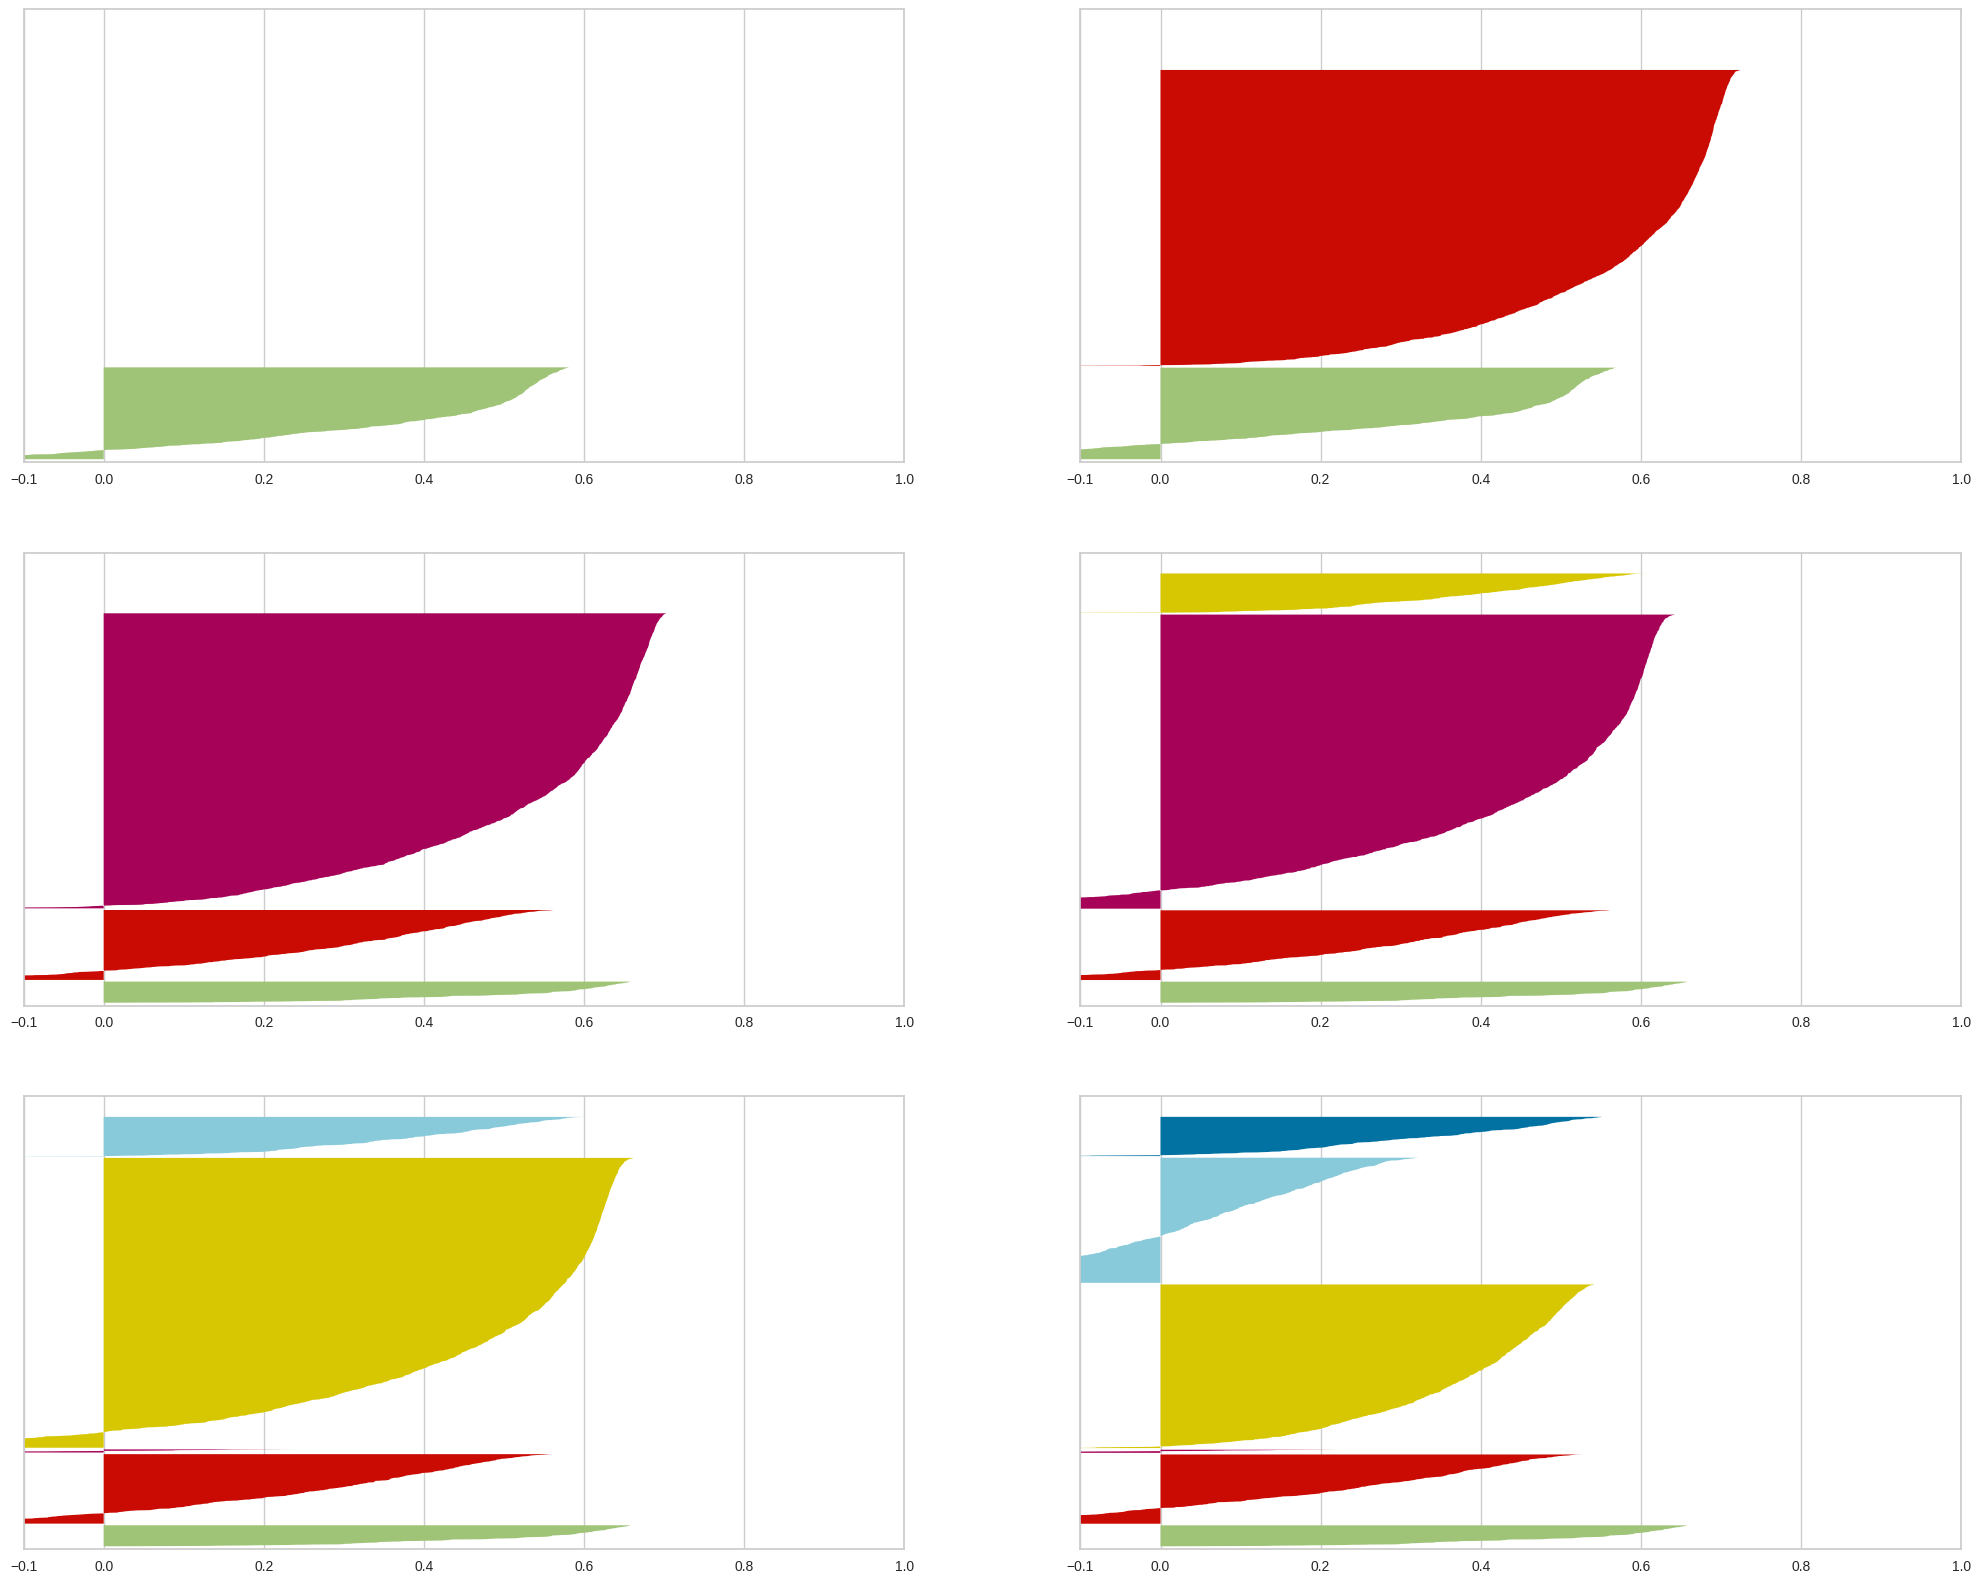

In [67]:
fig, ax = plt.subplots(3, 2)
fig.set_size_inches(25, 20)

for k in clusters:
    q, mod = divmod(k, 2)
    ax[q-1, mod].set_xlim([-0.1, 1])
    ax[q-1, mod].set_ylim([0, len(X) + (k+1)*10])
    
    # model definition and training
    hc_model = hc.linkage(X, 'ward')
    
    # model predict
    labels = hc.fcluster(hc_model, k, criterion='maxclust')
    
    # performance
    ss = m.silhouette_score(X, labels, metric='euclidean')
    print('For k = {}  |  Silhouette Score: {}'.format(k, ss))
    samples_silhouette_values = m.silhouette_samples(X, labels)
    
    y_lower = 10
    for i in range(k):     
        # select clusters
        ith_samples_silhouette_values = samples_silhouette_values[labels == i]
        
        # sort values
        ith_samples_silhouette_values.sort()
        
        # size clusters
        size_cluster_i = ith_samples_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        
        cmap = plt.get_cmap('Spectral')
        color = cmap(i/k)
                
        ax[q-1, mod].fill_betweenx(np.arange(y_lower, y_upper), 0, ith_samples_silhouette_values)
        
        y_lower = y_upper + 10
    ax[q-1, mod].set_yticks([])
    ax[q-1, mod].set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

# 8 - Model training

## 8.1 - K-Means

In [92]:
# mode definition
k = 5
kmeans = c.KMeans(init='random', n_clusters=k, n_init=10, max_iter=300)

# model training
kmeans.fit(X)

# clustering
labels = kmeans.labels_

## 8.2 - Cluster validation

In [94]:
# WSS
print('WSS value: {}'.format(kmeans.inertia_))

# Silhouette Score
print('SS value: {}'.format(me.silhouette_score(X, labels, metric='euclidean')))

WSS value: 35879671974.89336
SS value: 0.7731573427789148


# 9 - Cluster Analysis

In [95]:
df9 = df6.copy()
df9['cluster'] = labels

## 9.1 - Visualization Inspection

/home/fausto/repos/clustering/cluster/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


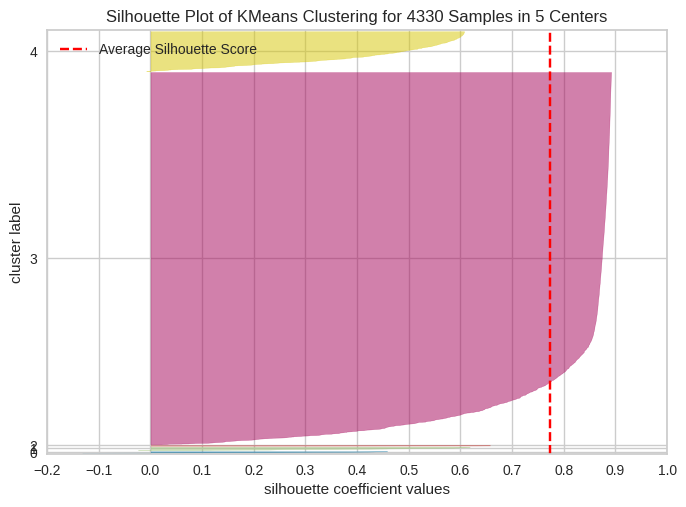

In [96]:
visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick')
visualizer.fit(X)
visualizer.finalize()

## 9.2 2d plot

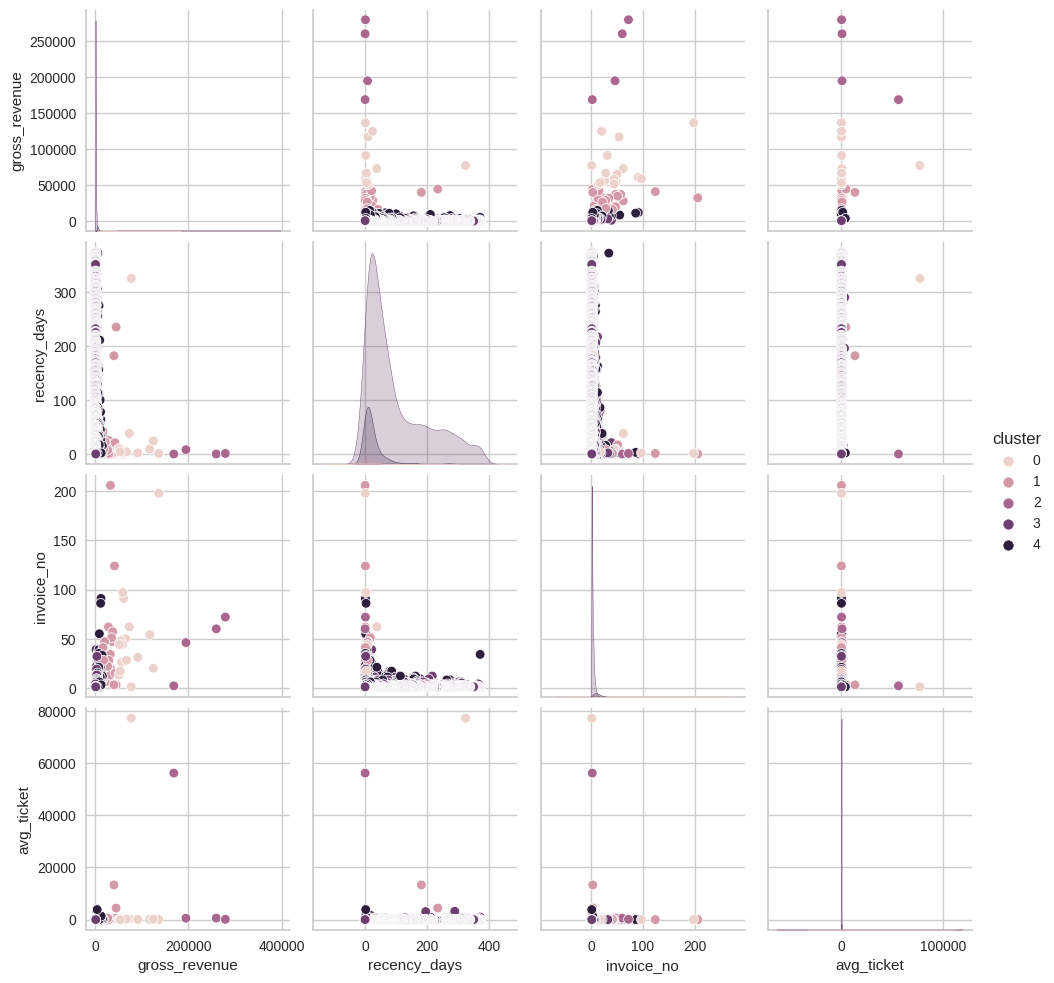

In [97]:
df_viz = df9.drop('customer_id', axis=1)
sns.pairplot(df_viz, hue='cluster');

## 9.3 UMAP

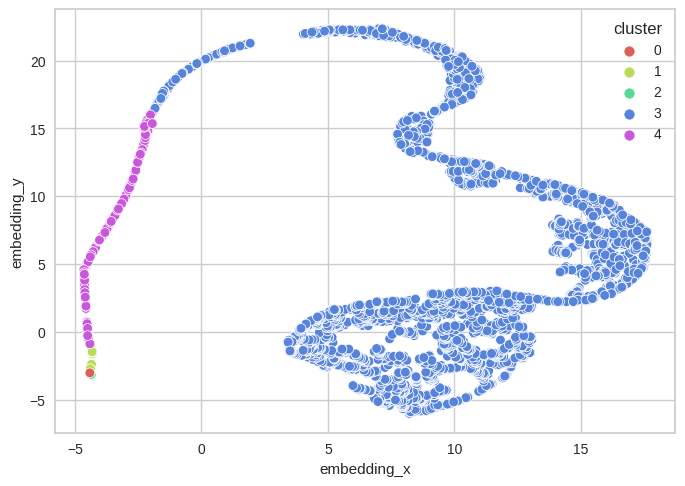

In [101]:
reducer = umap.UMAP(n_neighbors=15, random_state=42)
embedding = reducer.fit_transform(X)

# embedding
df_viz['embedding_x'] = embedding[:, 0]
df_viz['embedding_y'] = embedding[:, 1]

#plot UMAP
sns.scatterplot(x='embedding_x', y='embedding_y', hue='cluster', 
                palette=sns.color_palette('hls', n_colors=len(df_viz['cluster'].unique())),
                data=df_viz);

In [99]:
#fig = px.scatter_3d(df9, x='recency_days', y='invoice_no', z='gross_revenue', color='cluster')
#fig.show()

## 9.4 - Cluster Profile

In [100]:
# Number of customer
df_cluster = df9[['customer_id', 'cluster']].groupby('cluster').count().reset_index()
df_cluster['perc_customer'] = np.round(100*df_cluster['customer_id']/df_cluster['customer_id'].sum(), 2).astype(str)+'%'
df_cluster

# Avg gross_revenue
df_avg_gross_revenue = df9[['gross_revenue', 'cluster']].groupby('cluster').mean().reset_index()
df_avg_gross_revenue['gross_revenue'] = '$' + np.round(df_avg_gross_revenue['gross_revenue'], 2).astype(str)
df_cluster = pd.merge(df_cluster, df_avg_gross_revenue, how='inner', on='cluster')

# Avg recency_days
df_avg_recency_days = df9[['recency_days', 'cluster']].groupby('cluster').mean().reset_index()
df_avg_recency_days['recency_days'] = np.round(df_avg_recency_days['recency_days'], 2).astype(str) + ' dias'
df_cluster = pd.merge(df_cluster, df_avg_recency_days, how='inner', on='cluster')

# Avg invoice_no
df_avg_invoice_no = df9[['invoice_no', 'cluster']].groupby('cluster').mean().reset_index()
df_avg_invoice_no['invoice_no'] = np.round(df_avg_invoice_no['invoice_no'], 2).astype(str) + ' produtos'
df_cluster = pd.merge(df_cluster, df_avg_invoice_no, how='inner', on='cluster')

# Avg ticket
df_ticket = df9[['avg_ticket', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_ticket, how='inner', on='cluster')

df_cluster

,cluster,customer_id,perc_customer,gross_revenue,recency_days,invoice_no,avg_ticket
0,0,16,0.37%,$74629.98,27.56 dias,51.5 produtos,4988.347953
1,1,38,0.88%,$25173.13,17.79 dias,34.16 produtos,585.432464
2,2,4,0.09%,$225454.65,2.25 dias,45.0 produtos,14368.189768
3,3,3859,89.12%,$843.5,100.34 dias,2.85 produtos,28.482479
4,4,413,9.54%,$5931.88,26.19 dias,12.38 produtos,60.566959
